In [184]:
import joblib
import json 
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

import lightgbm as lgbm

from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [199]:
# Define functions to reuse later 
def plot_column(data, column, plot_size=(15, 6), save=False):
    ''' 
    Plots a column from the turbine dataset using the fivethirtyeight style.
    '''
    # Use tivethirtyeight as a sytle because it looks really nice
    plt.clf()
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=plot_size)

    # Plot the first 1000 datapoints of power generated
    plt.scatter(data.index, data[column], marker='.', alpha=0.6)

    # Set labels and rotate x labels for better readabilty
    plt.xlabel('Date')
    plt.xticks(rotation=50)
    plt.ylabel(column)
    if save:
        plt.savefig('column.png', dpi=100, bbox_inches = 'tight')


def plot_preds(test_data, predictions, interval_f=0, interval_t=300):
    ''' 
    Can be used to plot the predictions given by a model compared to the true values.
    '''
    plt.figure(figsize=(25, 6))

    # Plot the predicted and the acutal values on a line plot to see how well our model performed
    sns.lineplot(x=test_data.index[interval_f:interval_t], y=predictions[interval_f:interval_t], alpha=1, label='Predicted')
    sns.lineplot(x=test_data.index[interval_f:interval_t], y=test_data[interval_f:interval_t], alpha=1, label='Actual')

    # Labels and legend
    plt.xlabel('Date')
    plt.ylabel('Power generated')
    plt.legend()
    plt.show()

def interpolate(df, col_name, alpha=0.1):
    ''' 
    Interplotates some of the missing values in a column using the .interplotate and .ewm method of pandas.
    '''
    df['EMA'] = df[col_name].interpolate().ewm(alpha=alpha, adjust=True).mean()
    for index, row in df[[col_name, 'EMA']].iterrows():
        value = row[col_name]
        if np.isnan(value):
            df.loc[index, col_name] = row['EMA']
    
    df = df.drop('EMA', axis=1)
    return df


def rolling_features(df, column, win_size=12):
    '''
    Adds a rolling window with the min, mean and max values using the .rolling function provided by pandas
    '''

    df[f'rolling-{column}-{win_size}-min'] = df[column].rolling(win_size).min()
    df[f'rolling-{column}-{win_size}-mean'] = df[column].rolling(win_size).mean()
    df[f'rolling-{column}-{win_size}-max'] = df[column].rolling(win_size).max()

    return df


def expanding_features(df, column, win_size=12):
    '''
    Adds a expanding window with the min, mean and max values using the .expanding function provided by pandas
    '''

    df[f'expanding-{column}-{win_size}-min'] = df[column].expanding(win_size).min()
    df[f'expanding-{column}-{win_size}-mean'] = df[column].expanding(win_size).mean()
    df[f'expanding-{column}-{win_size}-max'] = df[column].expanding(win_size).max()

    return df


In [186]:
# Read in the data
data = pd.read_csv('turbine-data.csv')

# The unnamed column seems to be dates. Convert column to datetime and set as index
data = data.rename(columns={'Unnamed: 0': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Print out last five rows
data.head()

ActivePower  AmbientTemperatue  \
Date                                                        
2017-12-31 00:00:00+00:00          NaN                NaN   
2017-12-31 00:10:00+00:00          NaN                NaN   
2017-12-31 00:20:00+00:00          NaN                NaN   
2017-12-31 00:30:00+00:00          NaN                NaN   
2017-12-31 00:40:00+00:00          NaN                NaN   

                           BearingShaftTemperature  Blade1PitchAngle  \
Date                                                                   
2017-12-31 00:00:00+00:00                      NaN               NaN   
2017-12-31 00:10:00+00:00                      NaN               NaN   
2017-12-31 00:20:00+00:00                      NaN               NaN   
2017-12-31 00:30:00+00:00                      NaN               NaN   
2017-12-31 00:40:00+00:00                      NaN               NaN   

                           Blade2PitchAngle  Blade3PitchAngle  \
Date                                                            
2017-12-31 00:00:00+00:00               NaN               NaN   
2017-12-31 00:10:00+00:00               NaN               NaN   
2017-12-31 00:20:00+00:00               NaN               NaN   
2017-12-31 00:30:00+00:00               NaN               NaN   
2017-12-31 00:40:00+00:00               NaN               NaN   

                           ControlBoxTemperature  GearboxBearingTemperature  \
Date                                                                          
2017-12-31 00:00:00+00:00                    NaN                        NaN   
2017-12-31 00:10:00+00:00                    NaN                        NaN   
2017-12-31 00:20:00+00:00                    NaN                        NaN   
2017-12-31 00:30:00+00:00                    NaN                        NaN   
2017-12-31 00:40:00+00:00                    NaN                        NaN   

                           GearboxOilTemperature  GeneratorRPM  ...  \
Date                                                            ...   
2017-12-31 00:00:00+00:00                    NaN           NaN  ...   
2017-12-31 00:10:00+00:00                    NaN           NaN  ...   
2017-12-31 00:20:00+00:00                    NaN           NaN  ...   
2017-12-31 00:30:00+00:00                    NaN           NaN  ...   
2017-12-31 00:40:00+00:00                    NaN           NaN  ...   

                           GeneratorWinding2Temperature  HubTemperature  \
Date                                                                      
2017-12-31 00:00:00+00:00                           NaN             NaN   
2017-12-31 00:10:00+00:00                           NaN             NaN   
2017-12-31 00:20:00+00:00                           NaN             NaN   
2017-12-31 00:30:00+00:00                           NaN             NaN   
2017-12-31 00:40:00+00:00                           NaN             NaN   

                           MainBoxTemperature  NacellePosition  ReactivePower  \
Date                                                                            
2017-12-31 00:00:00+00:00                 NaN              NaN            NaN   
2017-12-31 00:10:00+00:00                 NaN              NaN            NaN   
2017-12-31 00:20:00+00:00                 NaN              NaN            NaN   
2017-12-31 00:30:00+00:00                 NaN              NaN            NaN   
2017-12-31 00:40:00+00:00                 NaN              NaN            NaN   

                           RotorRPM  TurbineStatus  WTG WindDirection  \
Date                                                                    
2017-12-31 00:00:00+00:00       NaN            NaN  G01           NaN   
2017-12-31 00:10:00+00:00       NaN            NaN  G01           NaN   
2017-12-31 00:20:00+00:00       NaN            NaN  G01           NaN   
2017-12-31 00:30:00+00:00       NaN            NaN  G01           NaN   
2017-12-31 00:40:00+00:00       NaN            NaN  G0

In [187]:
# Get hour, dayofweek and month out of the datetime collum
data['hour'] = [data.index[i].hour for i in range(len(data))]
data['dayofweek'] = [data.index[i].day for i in range(len(data))]
data['month'] = [data.index[i].month for i in range(len(data))]

In [188]:
# Get the rolling window from four of our columns
for col in ['AmbientTemperatue', 'WindSpeed', 'RotorRPM', 'ReactivePower']:
    data = rolling_features(data, col, win_size=6)

# # Get the expanding window from four of our columns
for col in ['AmbientTemperatue', 'WindSpeed', 'RotorRPM', 'ReactivePower']:
    data = expanding_features(data, col, win_size=6)


<Figure size 640x480 with 0 Axes>

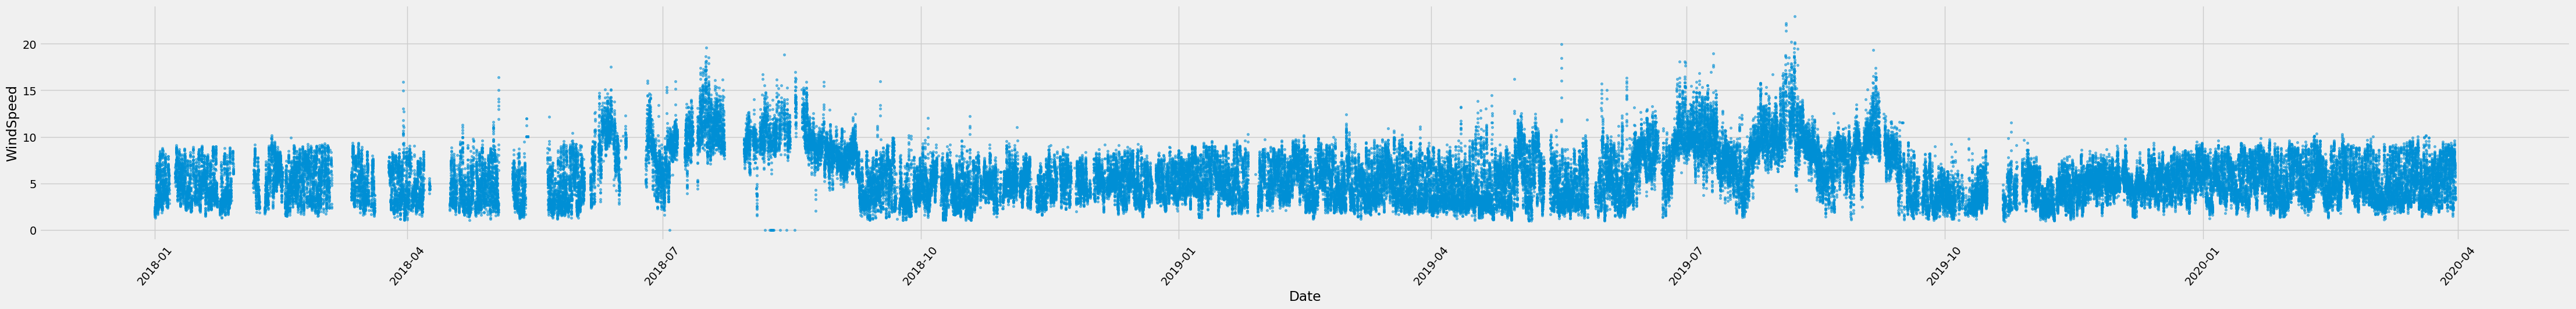

In [189]:
plot_column(data, column='WindSpeed', plot_size=(50, 5))

In [190]:
# Interpolate the data using the rolling mean
data = interpolate(data, 'WindSpeed')
data = interpolate(data, 'AmbientTemperatue')

In [ ]:
# Filter data by 1 year periods
data_2018 = data[(data.index >= '01.01.2018') & (data.index <= '31.12.2018')]
data_2019 = data[(data.index >= '01.01.2019') & (data.index <= '31.12.2019')]
data_2020 = data[(data.index >= '01.01.2020') & (data.index <= '31.12.2020')]

<Figure size 640x480 with 0 Axes>

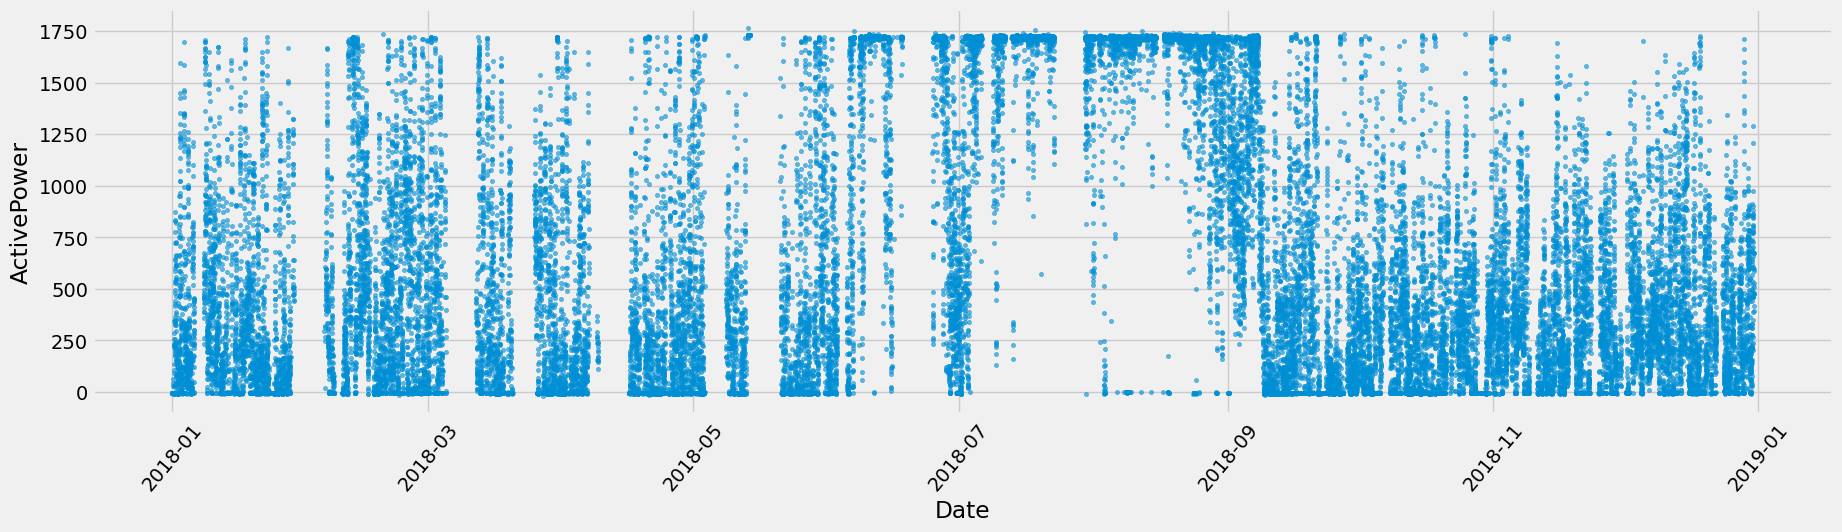

In [202]:
# Look at some of the data by year
plot_column(data_2018, column='ActivePower', plot_size=(20, 5))

<Figure size 640x480 with 0 Axes>

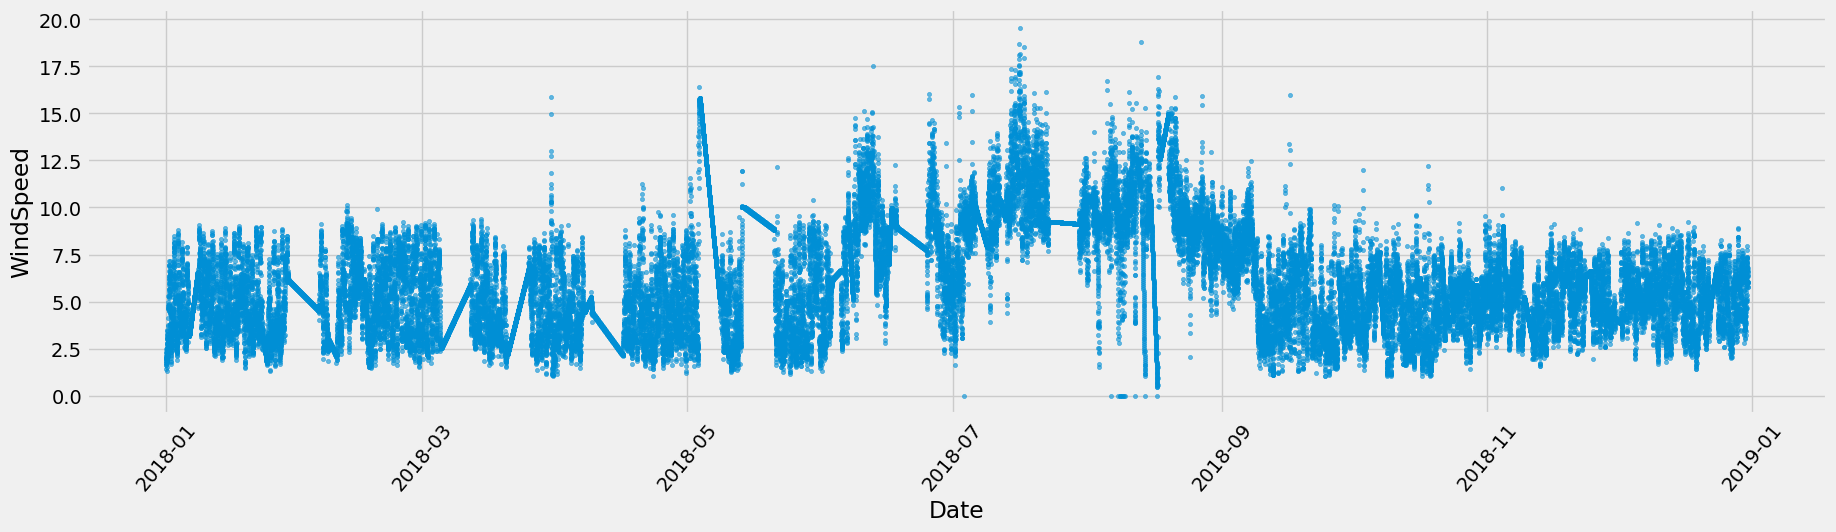

In [203]:
plot_column(data_2018, column='WindSpeed', plot_size=(20, 5))

<Figure size 640x480 with 0 Axes>

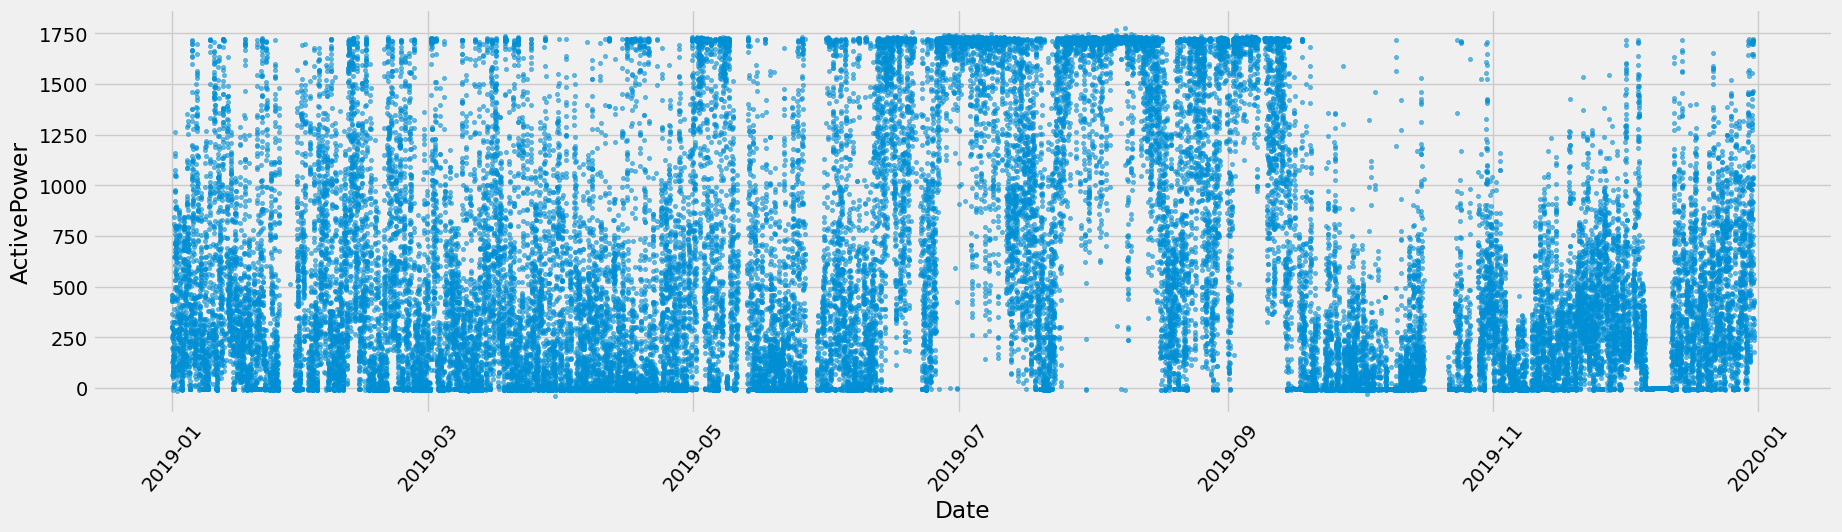

In [201]:
plot_column(data_2019, column='ActivePower', plot_size=(20, 5))

<Figure size 640x480 with 0 Axes>

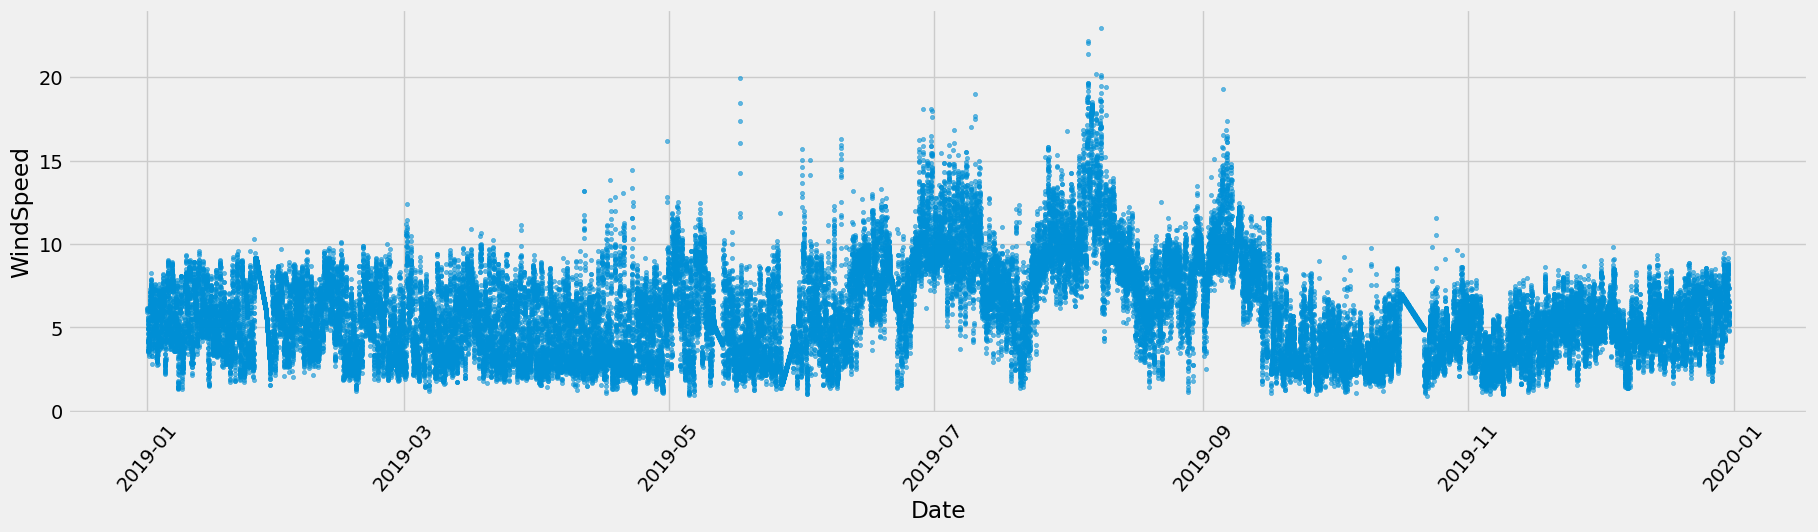

In [204]:
plot_column(data_2019, column='WindSpeed', plot_size=(20, 5))

<Figure size 640x480 with 0 Axes>

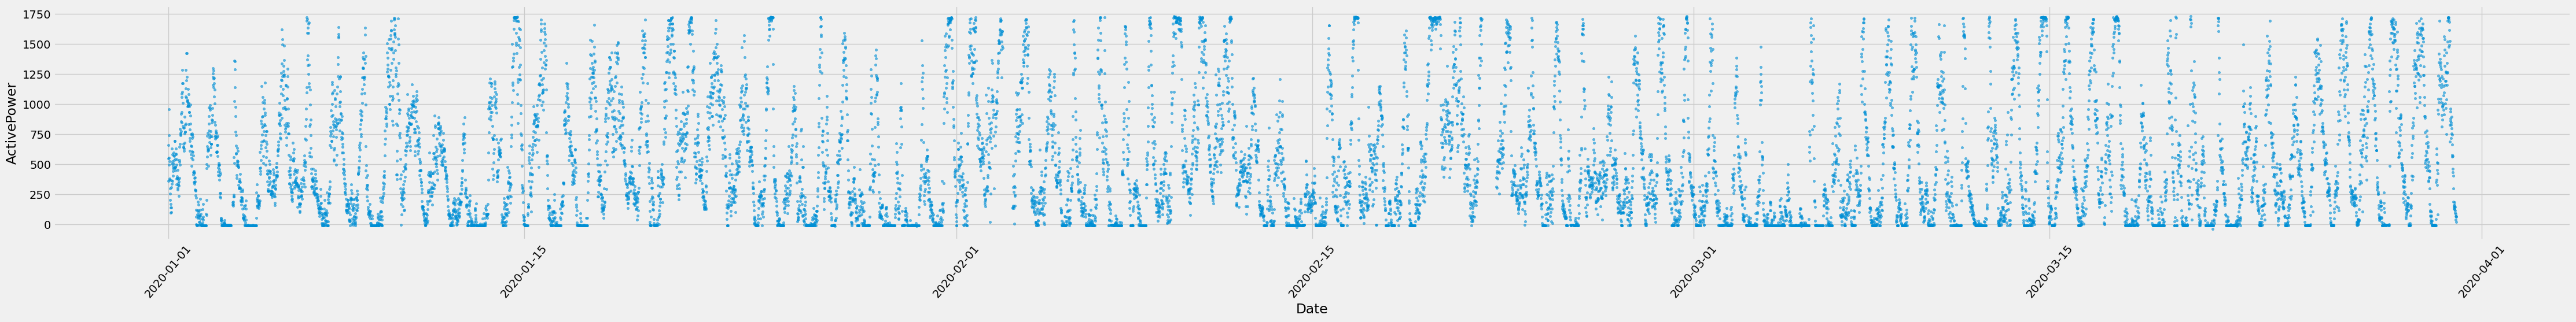

In [206]:
plot_column(data_2020, column='ActivePower', plot_size=(50, 5))

<Figure size 640x480 with 0 Axes>

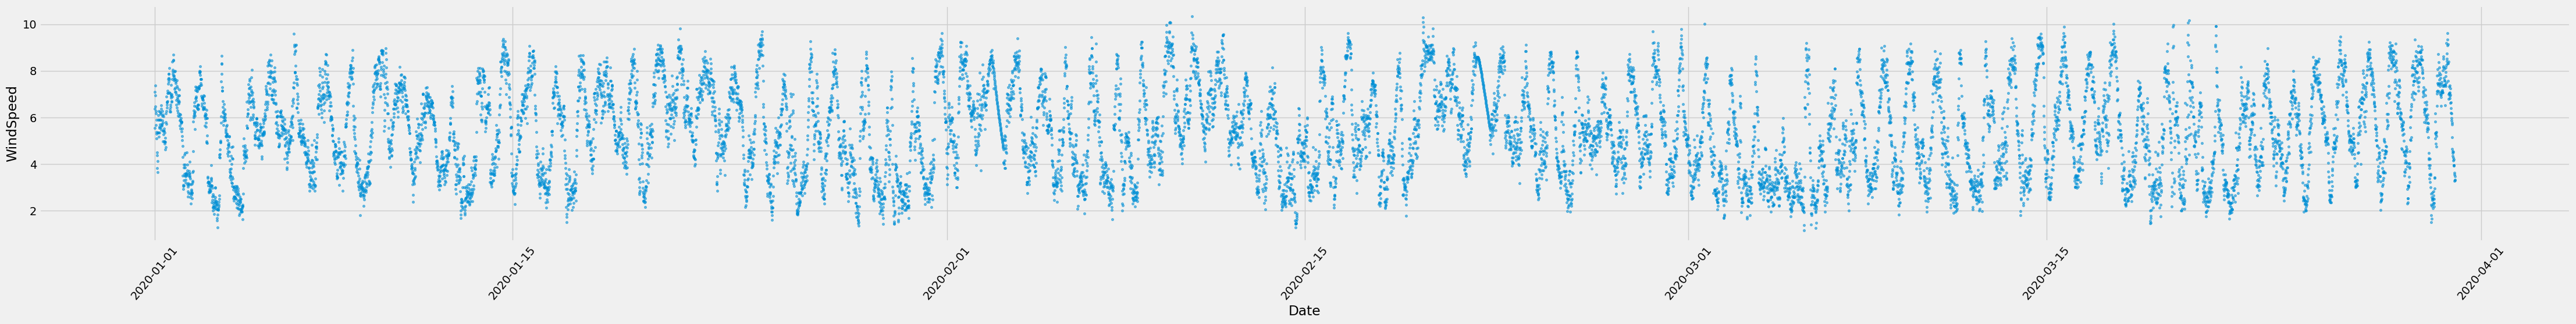

In [151]:
plot_column(data_2020, column='WindSpeed', plot_size=(50, 5))

In [152]:
# Shift the values of the power 
# Predicted value if for 60 Minutes in the future
data['ActivePower'] = data.ActivePower.shift(6)
data = data.fillna(method='bfill') # Fill missing value caused by shift

In [155]:
# Split up data into X (features) any y (targets)
X = data.drop(['ActivePower', 'WTG'], axis=1).to_numpy()
y = data.ActivePower

# Do a simple train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# Define hyperparamter space
lgbm_space = {
    'num_leaves': hp.choice("num_leaves", np.arange(2, 100, dtype=int)),
    'max_depth' : hp.choice('max_depth', np.arange(5, 100, dtype=int)),
    'n_estimators' : hp.choice('n_estimators', np.arange(75, 200, dtype=int)),
    'learning_rate' : hp.choice('learning_rate', [x / 100.0 for x in range(1, 100)]),
    'reg_lambda' : hp.choice('reg_lambda', [x / 100.0 for x in range(1, 100)]),
    'reg_alpha' : hp.choice('reg_alpha', [x / 100.0 for x in range(1, 100)]),
}

# Objective function
def objective(params):
        model = lgbm.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        mse = mean_squared_error(y_test, y_hat)
        return {'loss': mse, 'status': STATUS_OK}

# Trials to track progress
bayes_trials = Trials()

# Use the space and objective above to find best parameters
lgbm_best_params = fmin(fn=objective, space=lgbm_space, algo=tpe.suggest, max_evals=128, trials=bayes_trials, return_argmin=False)

100%|██████████| 128/128 [01:17<00:00,  1.64trial/s, best loss: 21442.13311608736] 


In [123]:
lgbm_best_params

{'learning_rate': 0.34,
 'max_depth': 20,
 'n_estimators': 170,
 'num_leaves': 96,
 'reg_alpha': 0.93,
 'reg_lambda': 0.46}

In [130]:
# Load in a model with the found paramters
lgbm_model = lgbm.LGBMRegressor(**lgbm_best_params)

In [170]:
# Cross-validate on differnt metrics to make sure our model performs well on all parts of the data
scoring_list = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']
for metric in scoring_list:
    cv = KFold(n_splits=5)
    scores = cross_val_score(lgbm_model, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    print(f'Scores for: {metric}')
    print(scores.tolist())
    print('- - - - - - - - - - - -')

Scores for: r2
[0.9527941443206366, 0.9517009352349324, 0.9515177351558106, 0.9486116199529997, 0.9512104992541873]
- - - - - - - - - - - -
Scores for: neg_mean_absolute_error
[-76.57288273676858, -75.18944684435223, -76.03864566042276, -77.24755518447033, -76.84475723549205]
- - - - - - - - - - - -
Scores for: neg_mean_squared_error
[-17969.916476616865, -18290.16273990022, -18284.604474959273, -18951.66920172958, -18328.540070382973]
- - - - - - - - - - - -
Scores for: neg_root_mean_squared_error
[-134.05191709415, -135.24112813748715, -135.2205771136896, -137.6650616595568, -135.3829386236795]
- - - - - - - - - - - -


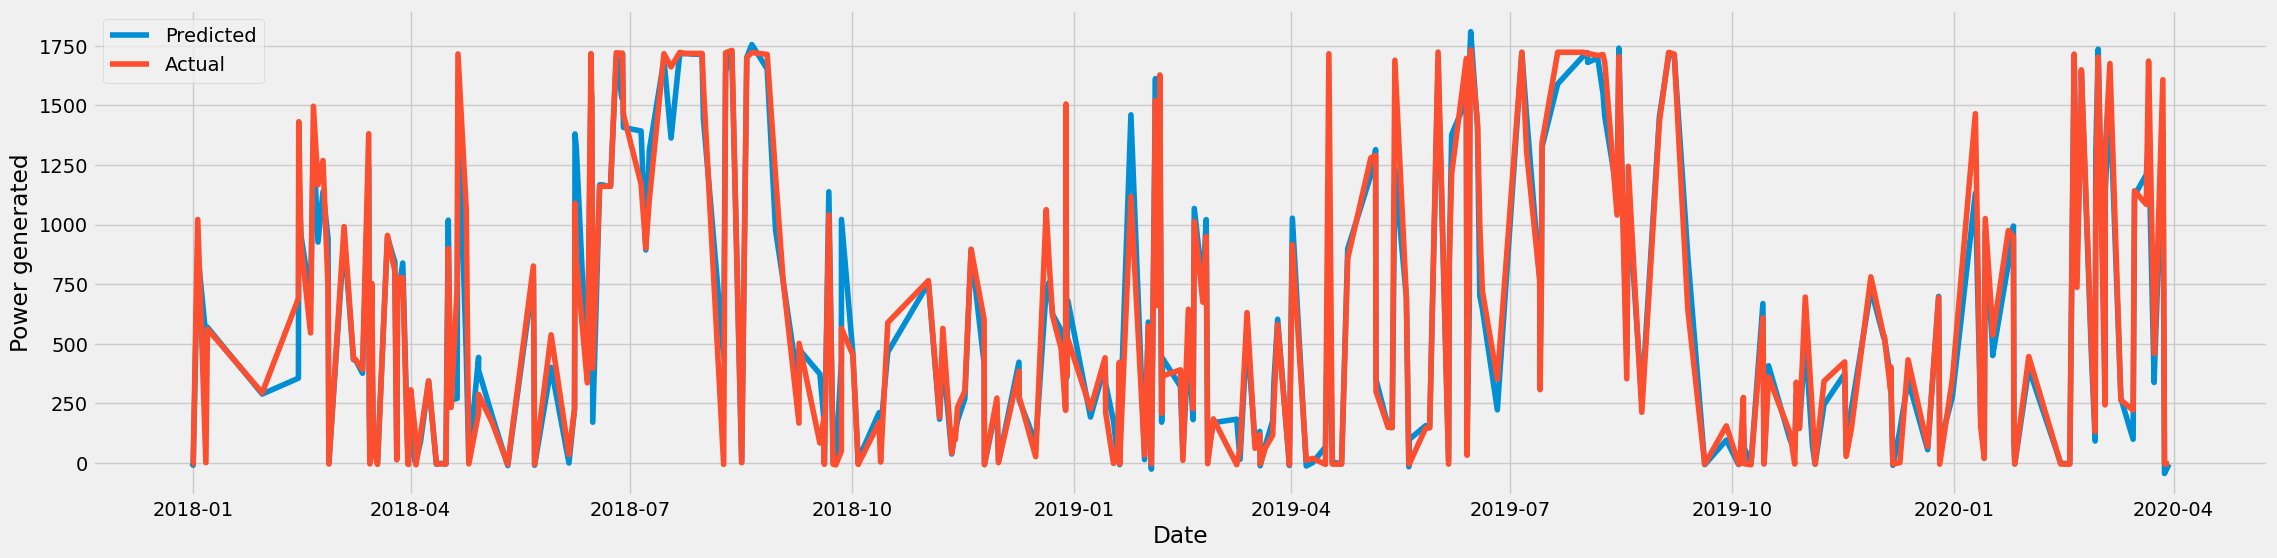

In [171]:
# Plot how well our model fitted to the data
lgbm_model.fit(X_train, y_train)
y_hat = lgbm_model.predict(X_test)
plot_preds(y_test, y_hat)

In [172]:
# If results are satisfactory, fit final approved model with all of the data
approved_model = lgbm.LGBMRegressor(**lgbm_best_params)
approved_model.fit(X, y)

LGBMRegressor(learning_rate=0.34, max_depth=20, n_estimators=170, num_leaves=96,
              reg_alpha=0.93, reg_lambda=0.46)

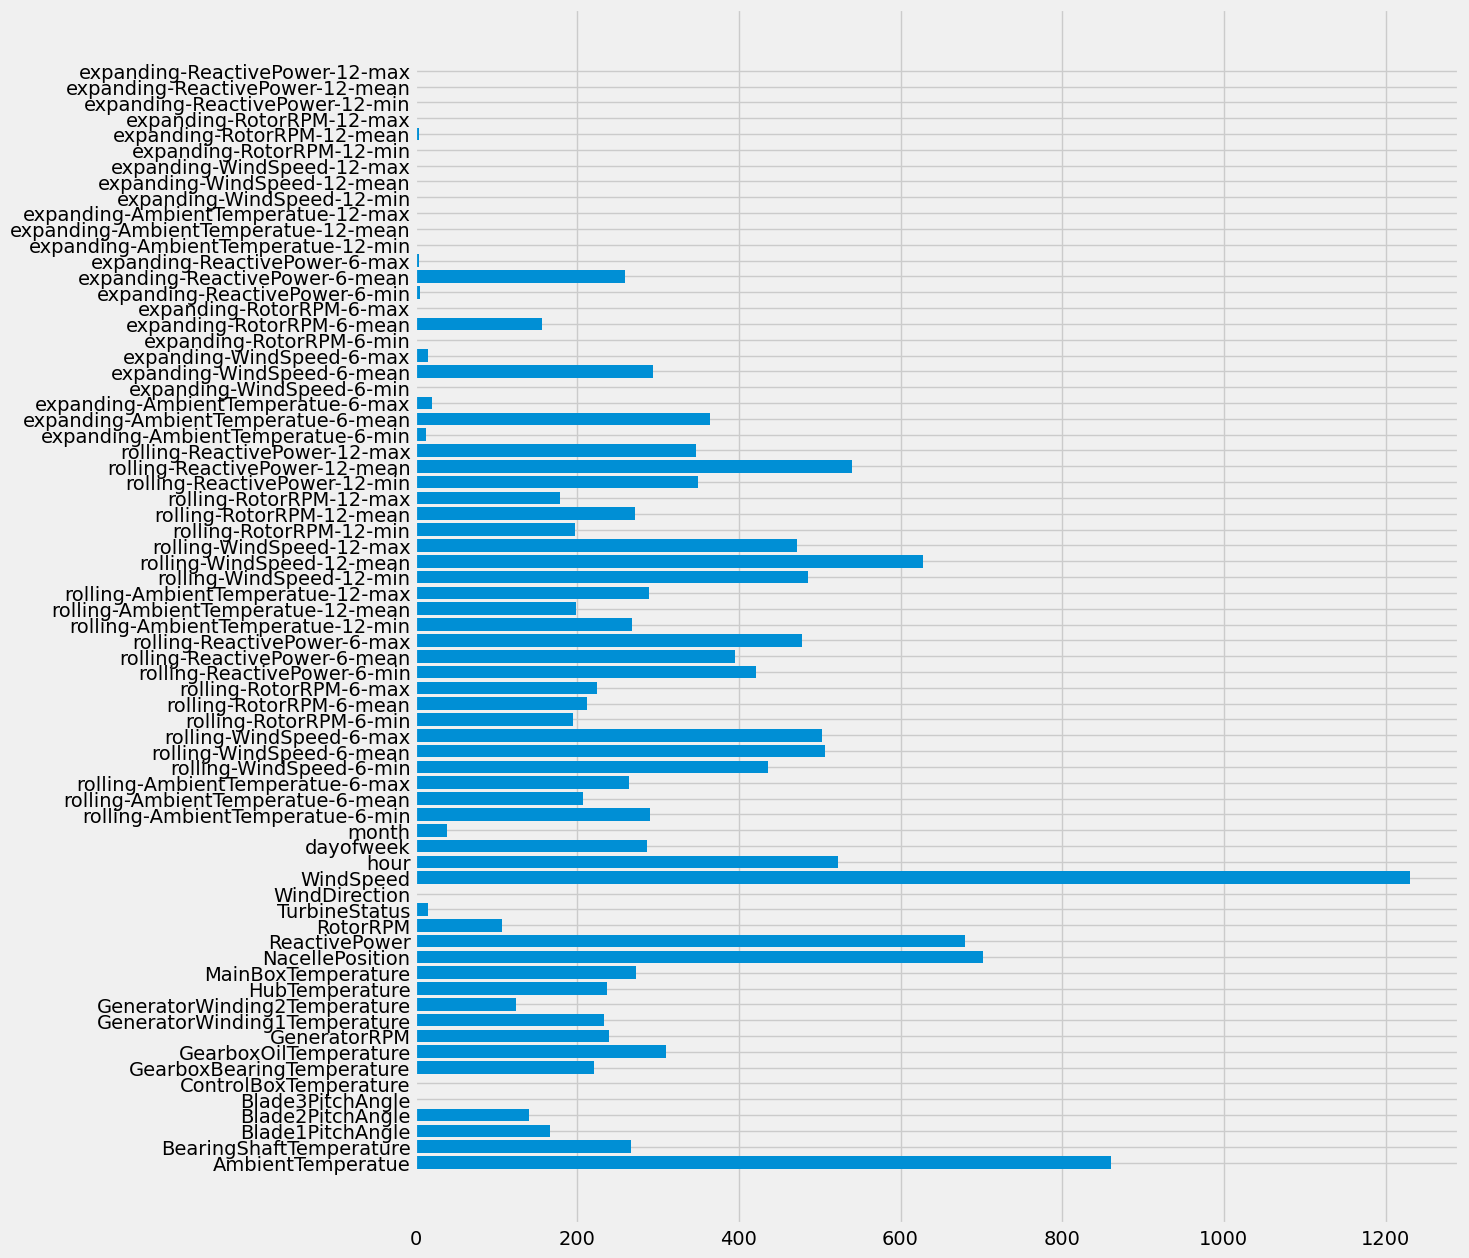

In [176]:
# Let's take a look at the feature importances 
values = approved_model.feature_importances_

columns = data.columns.to_list()
columns = [i for i in columns if i not in ('ActivePower', 'WTG')]

plt.figure(figsize=(12, 15))
plt.barh(columns, values)
plt.show()

In [177]:
# Save model
joblib.dump(approved_model, 'model.pkl')

['model.pkl']

In [209]:
# Take a subset of our test data and save it so JSON format
entry = data.head(5)
entry.to_json('data.json')

# Load the JSON data
with open('data.json') as f:
    json_data = json.load(f)

In [214]:
# Send request to our serverless function
URL = 'URL OF MODEL GOES HERE'
headers = {'Content-type': 'application/json'}
req = requests.post(URL, json=json.dumps(json_data))
print(req.text)